In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import mpl_lego as mplego
import pandas as pd

from hatespeech import keys, utils
from IPython.display import Markdown
from scipy.stats import f_oneway, kruskal

%matplotlib inline

In [2]:
mplego.style.use_latex_style()

In [3]:
exp = "22"
base_path = os.path.join(os.environ['HOME'], 'projects/hatespeech-2021-fairml')
data_path = "~/data/hatespeech/unfiltered_ratings.feather"
rater_quality_path = "~/data/hatespeech/rater_quality_check.csv"
results_path = os.path.join(base_path, f'scaling/experiments/exp{exp}')

In [4]:
data = pd.read_feather(data_path).rename(columns={'violence_phys': 'violence'})
# Remove all rows in which some item is missing
data = utils.filter_missing_items(data)
# Remove all rows in which the rater is not up to sufficient quality
rater_quality = pd.read_csv(rater_quality_path)
data = utils.filter_annotator_quality(data, rater_quality)
# Recode item responses
data = utils.recode_responses(
    data,
    insult={1: 0, 2: 1, 3: 2, 4: 3},
    humiliate={1: 0, 2: 0, 3: 1, 4: 2},
    status={1: 0, 2: 0, 3: 1, 4: 1},
    dehumanize={1: 0, 2: 0, 3: 1, 4: 1},
    violence={1: 0, 2: 0, 3: 1, 4: 1},
    genocide={1: 0, 2: 0, 3: 1, 4: 1},
    attack_defend={1: 0, 2: 1, 3: 2, 4: 3},
    hatespeech={1: 0, 2: 1})
# Only get comments targeting black / white people
data = data[data['target_race_white'] | data['target_race_black']]
data = data[data[keys.target_race_cols].sum(axis=1) == 1]
data['target_race'] = np.where(data['target_race_white'], 1, 2)

In [5]:
out_path = os.path.join(results_path, f"exp{exp}_out.txt")

In [6]:
with open(out_path) as f:
    lines = f.readlines()

In [7]:
bias_lines = lines[17588:30364]

In [8]:
bias_cut = bias_lines[4:-7]

In [30]:
n_samples = len(bias_cut)
observed = np.zeros(n_samples)
expected = np.zeros(n_samples)
bias_size = np.zeros(n_samples)
t_stats = np.zeros(n_samples)
p_vals = np.zeros(n_samples)
labeler_id = np.zeros(n_samples)
measure = np.zeros(n_samples)
race = np.zeros(n_samples)

for idx, line in enumerate(bias_cut):
    processed = line.replace('|', ' ').replace('>', ' ').replace('<', ' ').split()
    observed[idx] = float(processed[0])
    expected[idx] = float(processed[1])
    bias_size[idx] = float(processed[4])
    t_stats[idx] = float(processed[6])
    p_vals[idx] = float(processed[8])
    labeler_id[idx] = int(processed[13])
    measure = float(processed[14])
    if processed[16] == 'white':
        race[idx] = 0
    elif processed[16] == 'black':
        race[idx] = 1

In [31]:
df = pd.DataFrame({
    'observed': observed,
    'expected': expected,
    'bias': bias_size,
    't_statistics': t_stats,
    'p_values': p_vals,
    'labeler_id': labeler_id,
    'measure': measure,
    'race': race}).astype({'labeler_id': int})

In [32]:
df['annotator_race'] = 0
subview = data[data['labeler_id'].isin(df['labeler_id'])].drop_duplicates('labeler_id')
df.loc[df['labeler_id'].isin(subview[subview['annotator_race_black']]['labeler_id']), 'annotator_race'] = 1

In [33]:
df['bias_corrected'] = -df['bias']
df['bias_abs'] = df['bias'].abs()
df['annotator_race_name'] = np.where(df['annotator_race'] == 1, 'black', 'white')
df['target_race_name'] = np.where(df['race'] == 1, 'black', 'white')

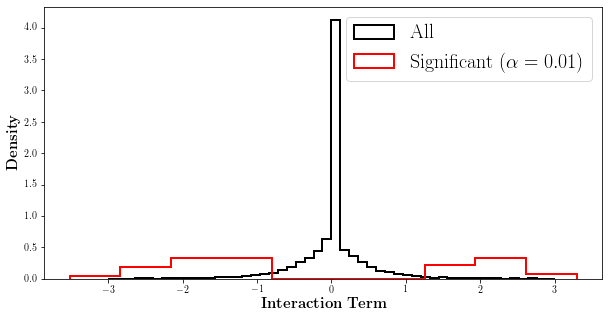

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(df['bias_corrected'], bins=np.linspace(-3, 3, 51), histtype='step', color='black', lw=2, density=True, label='All')
ax.hist(df[df['p_values'] < 0.01]['bias'], color='red', histtype='step', density=True, lw=2, label=r'Significant ($\alpha=0.01$)')
ax.set_xlabel(r'\textbf{Interaction Term}', fontsize=15)
ax.set_ylabel(r'\textbf{Density}', fontsize=15)
ax.legend(prop={'size': 20})
#plt.savefig('interaction_terms.png', dpi=300)

In [29]:
df[(df['annotator_race'] == 0) & (df['race'] == 0)]['bias']

Series([], Name: bias, dtype: float64)

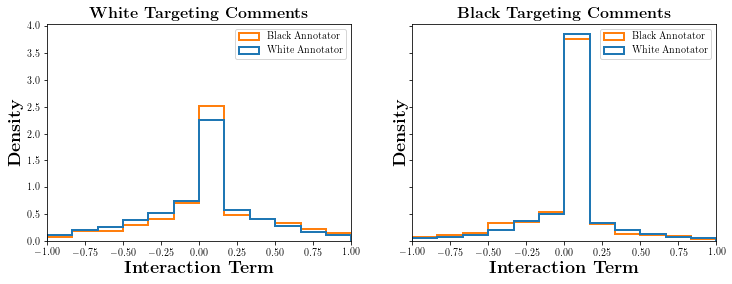

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axes[0].hist(
    [df[(df['annotator_race'] == 0) & (df['race'] == 0)]['bias_corrected'],
     df[(df['annotator_race'] == 1) & (df['race'] == 0)]['bias_corrected']],
    histtype='step',
    density=True,
    lw=2,
    bins=np.linspace(-1, 1, 13),
    label=['White Annotator', 'Black Annotator']
)

axes[1].hist(
    [df[(df['annotator_race'] == 0) & (df['race'] == 1)]['bias_corrected'],
     df[(df['annotator_race'] == 1) & (df['race'] == 1)]['bias_corrected']],
    histtype='step',
    density=True,
    lw=2,
    bins=np.linspace(-1, 1, 13),
    label=['White Annotator', 'Black Annotator']
)

axes[0].set_title(r'\textbf{White Targeting Comments}', fontsize=16)
axes[1].set_title(r'\textbf{Black Targeting Comments}', fontsize=16)

for ax in axes:
    ax.legend()
    ax.set_xlim([-1, 1])
    ax.set_xlabel(r'\textbf{Interaction Term}', fontsize=18)
    ax.set_ylabel(r'\textbf{Density}', fontsize=18)

#plt.savefig('interaction_terms_all_annotators.png', dpi=300)

In [27]:
df['annotator_race'].value_counts()

0    11446
1     1319
Name: annotator_race, dtype: int64

In [167]:
df['p_values'].sort_values()

10641    0.0000
3504     0.0001
5433     0.0003
3568     0.0005
10666    0.0006
          ...  
9734     1.0000
6810     1.0000
9736     1.0000
9726     1.0000
6382     1.0000
Name: p_values, Length: 12765, dtype: float64

In [ ]:
plt.hist(df['p_values'], np.lins)

(array([20., 21., 19., 26., 16., 23., 23., 28., 20., 25., 30., 24., 23.,
        16., 22., 29., 33., 32., 31., 23.]),
 array([0.0001  , 0.005095, 0.01009 , 0.015085, 0.02008 , 0.025075,
        0.03007 , 0.035065, 0.04006 , 0.045055, 0.05005 , 0.055045,
        0.06004 , 0.065035, 0.07003 , 0.075025, 0.08002 , 0.085015,
        0.09001 , 0.095005, 0.1     ]),
 <BarContainer object of 20 artists>)

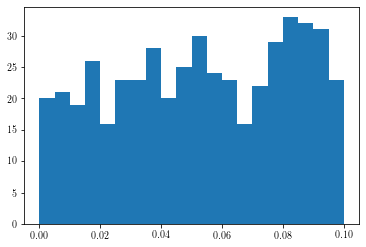

In [170]:
plt.hist(df['p_values'], bins=np.linspace(0.0001, 0.1, 21))
#plt.xlim([0.00001, 0.1])
#plt.xscale('log')

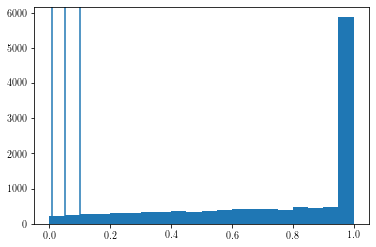

In [177]:
plt.hist(df['p_values'], bins=np.linspace(0, 1, 21))
plt.axvline(0.01)
plt.axvline(0.05)
plt.axvline(0.1)

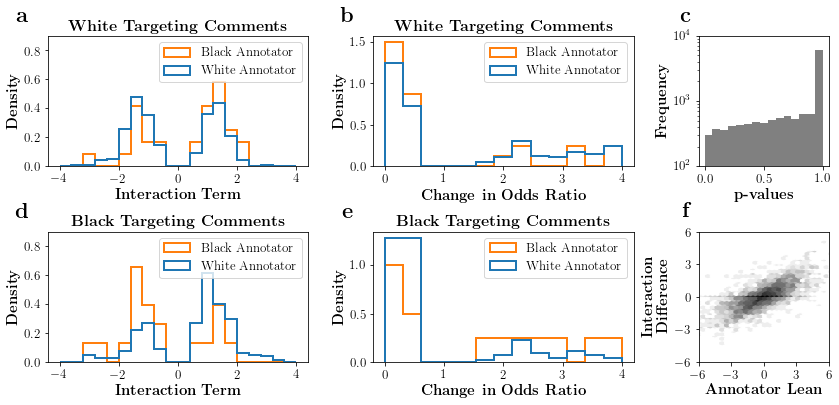

In [255]:
fig, axes = plt.subplots(2, 3, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1, 0.5]})
plt.subplots_adjust(wspace=0.3, hspace=0.5)

axes[0, 0].hist(
    [df[(df['annotator_race'] == 0) & (df['race'] == 0) & (df['p_values'] < 0.1)]['bias_corrected'],
     df[(df['annotator_race'] == 1) & (df['race'] == 0) & (df['p_values'] < 0.1)]['bias_corrected']],
    histtype='step',
    density=True,
    bins=np.linspace(-4, 4, 21),
    lw=2,
    label=['White Annotator', 'Black Annotator']
)

axes[1, 0].hist(
    [df[(df['annotator_race'] == 0) & (df['race'] == 1) & (df['p_values'] < 0.1)]['bias_corrected'],
     df[(df['annotator_race'] == 1) & (df['race'] == 1) & (df['p_values'] < 0.1)]['bias_corrected']],
    histtype='step',
    density=True,
    lw=2,
    bins=np.linspace(-4, 4, 21),
    label=['White Annotator', 'Black Annotator']
)

axes[0, 0].set_title(r'\textbf{White Targeting Comments}', fontsize=16)
axes[0, 1].set_title(r'\textbf{White Targeting Comments}', fontsize=16)
axes[1, 0].set_title(r'\textbf{Black Targeting Comments}', fontsize=16)
axes[1, 1].set_title(r'\textbf{Black Targeting Comments}', fontsize=16)


axes[0, 2].hist(df['p_values'], bins=np.linspace(0, 1, 16), color='gray')
axes[0, 2].set_yscale('log')
axes[0, 2].set_ylim([1e2, 1e4])
axes[0, 2].set_xlabel(r'\textbf{p-values}', fontsize=15)

axes[0, 1].hist(
    [np.exp(-df[(df['annotator_race'] == 0) & (df['race'] == 0) & (df['p_values'] < 0.1)]['bias_corrected']),
     np.exp(-df[(df['annotator_race'] == 1) & (df['race'] == 0) & (df['p_values'] < 0.1)]['bias_corrected'])],
    histtype='step',
    density=True,
    bins=np.linspace(0, 4, 14),
    lw=2,
    label=['White Annotator', 'Black Annotator']
)

axes[1, 1].hist(
    [np.exp(-df[(df['annotator_race'] == 0) & (df['race'] == 1) & (df['p_values'] < 0.1)]['bias_corrected']),
     np.exp(-df[(df['annotator_race'] == 1) & (df['race'] == 1) & (df['p_values'] < 0.1)]['bias_corrected'])],
    histtype='step',
    density=True,
    lw=2,
    bins=np.linspace(0, 4, 14),
    label=['White Annotator', 'Black Annotator']
)

for ax in axes[:2, :2].ravel():
    ax.legend(loc='best', prop={'size': 13})
    ax.set_ylabel(r'\textbf{Density}', fontsize=15)

for ax in axes[:, 0]:
    ax.set_xlabel(r'\textbf{Interaction Term}', fontsize=15)
for ax in axes[:, 1]:
    ax.set_xlabel(r'\textbf{Change in Odds Ratio}', fontsize=15)

axes[1, 2].hexbin(
    ruff['severity_diffs'],
    ruff['interaction_diffs'],
    cmap='Greys',
    bins='log',
    gridsize=40)
axes[1, 2].set_xlim([-6, 6])
axes[1, 2].set_ylim([-6, 6])
axes[1, 2].set_aspect('equal')
axes[1, 2].set_xticks([-6, -3, 0, 3, 6])
axes[1, 2].set_yticks([-6, -3, 0, 3, 6])

axes[0, 2].set_ylabel(r'\textbf{Frequency}', fontsize=15)

for ax in axes[:, 0]:
    ax.set_ylim(top=0.90)

for ax in axes.ravel():
    ax.tick_params(labelsize=13)
    
axes[1, 2].set_xlabel(r'\textbf{Annotator Lean}', fontsize=15)
axes[1, 2].set_ylabel(r'\textbf{Interaction}' '\n' r'\textbf{Difference}', fontsize=15)
mplego.labels.apply_subplot_labels(axes, bold=True, size=22, x=-0.1, y=1.15)
plt.savefig('figure4.pdf', bbox_inches='tight')

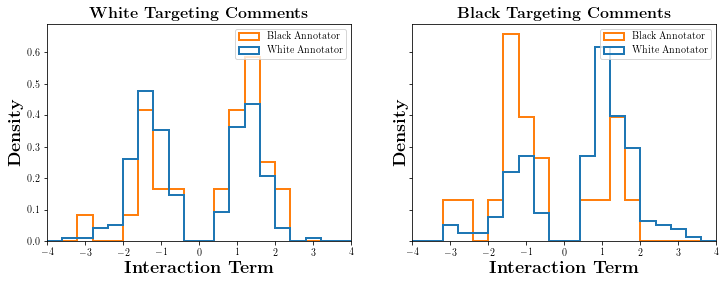

In [178]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axes[0].hist(
    [df[(df['annotator_race'] == 0) & (df['race'] == 0) & (df['p_values'] < 0.1)]['bias_corrected'],
     df[(df['annotator_race'] == 1) & (df['race'] == 0) & (df['p_values'] < 0.1)]['bias_corrected']],
    histtype='step',
    density=True,
    bins=np.linspace(-4, 4, 21),
    lw=2,
    label=['White Annotator', 'Black Annotator']
)

axes[1].hist(
    [df[(df['annotator_race'] == 0) & (df['race'] == 1) & (df['p_values'] < 0.1)]['bias_corrected'],
     df[(df['annotator_race'] == 1) & (df['race'] == 1) & (df['p_values'] < 0.1)]['bias_corrected']],
    histtype='step',
    density=True,
    lw=2,
    bins=np.linspace(-4, 4, 21),
    label=['White Annotator', 'Black Annotator']
)

axes[0].set_title(r'\textbf{White Targeting Comments}', fontsize=16)
axes[1].set_title(r'\textbf{Black Targeting Comments}', fontsize=16)

for ax in axes:
    ax.legend(loc='best')
    ax.set_xlim([-4, 4])
    ax.set_xlabel(r'\textbf{Interaction Term}', fontsize=18)
    ax.set_ylabel(r'\textbf{Density}', fontsize=18)
    
#plt.savefig('interaction_terms_significant_annotators.png', dpi=300)

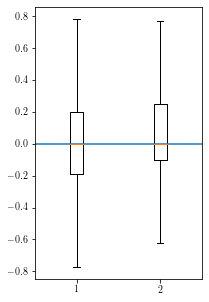

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(3, 5))

ax.boxplot(
    x=[df[(df['annotator_race'] == 0) & (df['race'] == 0)]['bias_corrected'],
       df[(df['annotator_race'] == 1) & (df['race'] == 0)]['bias_corrected']],
    showfliers=False
)
ax.axhline(0)

In [51]:
np.median(df[(df['annotator_race'] == 0) & (df['race'] == 0)]['bias_corrected'])

0.0

In [52]:
np.median(df[(df['annotator_race'] == 1) & (df['race'] == 0)]['bias_corrected'])

0.0

In [53]:
df[(df['annotator_race'] == 0) & (df['race'] == 0)]['bias_corrected']

0       0.09
1       0.41
2      -0.39
3      -0.00
4      -0.04
        ... 
4747    0.33
4748   -0.00
4749   -0.00
4750    0.46
4751   -0.00
Name: bias_corrected, Length: 4251, dtype: float64

In [71]:
df[(df['annotator_race'] == 1) & (df['race'] == 1)]['bias_corrected'].shape

(818,)

In [75]:
from scipy.stats import f_oneway, kruskal

f_oneway(
    df[(df['annotator_race'] == 0) & (df['race'] == 0)]['bias_corrected'].values,
    df[(df['annotator_race'] == 1) & (df['race'] == 0)]['bias_corrected'].values)

F_onewayResult(statistic=8.704003943516497, pvalue=0.003190624491126266)

In [41]:
f_oneway(
df[(df['annotator_race'] == 0) & (df['race'] == 1) & (df['p_values'] < 1)]['bias_corrected'],
     df[(df['annotator_race'] == 1) & (df['race'] == 1) & (df['p_values'] < 1)]['bias_corrected'])

F_onewayResult(statistic=9.549641870183601, pvalue=0.0020079678537736046)

In [151]:
np.median(df[(df['annotator_race'] == 1) & (df['race'] == 0) & (df['p_values'] < 0.1)]['bias_corrected'])

0.855

In [80]:
target_black = df[df['race'] == 1].copy()
target_white = df[df['race'] == 0].copy()
common_annotators = target_black[target_black['labeler_id'].isin(target_white['labeler_id'])]['labeler_id'].values

In [90]:
diffs = (target_black[target_black['labeler_id'].isin(common_annotators)].sort_values('labeler_id')['bias_corrected'].reset_index(drop=True)
         - target_white[target_white['labeler_id'].isin(common_annotators)].sort_values('labeler_id')['bias_corrected'].reset_index(drop=True))

In [94]:
interaction_diffs = pd.DataFrame(data={'labeler_id': np.sort(common_annotators), 'interaction_diffs': diffs})

In [96]:
sev_diffs = pd.read_csv('severity_diffs.csv')

In [103]:
ruff = sev_diffs.merge(interaction_diffs, how='inner', on='labeler_id')

In [111]:
np.corrcoef(ruff['severity_diffs'], ruff['interaction_diffs'])

array([[1.        , 0.70916585],
       [0.70916585, 1.        ]])

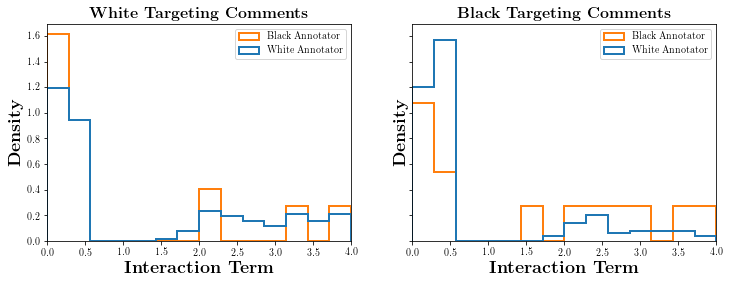

In [198]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axes[0].hist(
    [np.exp(-df[(df['annotator_race'] == 0) & (df['race'] == 0) & (df['p_values'] < 0.1)]['bias_corrected']),
     np.exp(-df[(df['annotator_race'] == 1) & (df['race'] == 0) & (df['p_values'] < 0.1)]['bias_corrected'])],
    histtype='step',
    density=True,
    bins=np.linspace(0, 4, 15),
    lw=2,
    label=['White Annotator', 'Black Annotator']
)

axes[1].hist(
    [np.exp(-df[(df['annotator_race'] == 0) & (df['race'] == 1) & (df['p_values'] < 0.1)]['bias_corrected']),
     np.exp(-df[(df['annotator_race'] == 1) & (df['race'] == 1) & (df['p_values'] < 0.1)]['bias_corrected'])],
    histtype='step',
    density=True,
    lw=2,
    bins=np.linspace(0, 4, 15),
    label=['White Annotator', 'Black Annotator']
)

axes[0].set_title(r'\textbf{White Targeting Comments}', fontsize=16)
axes[1].set_title(r'\textbf{Black Targeting Comments}', fontsize=16)

for ax in axes:
    ax.legend(loc='best')
    ax.set_xlim([0, 4])
    ax.set_xlabel(r'\textbf{Interaction Term}', fontsize=18)
    ax.set_ylabel(r'\textbf{Density}', fontsize=18)

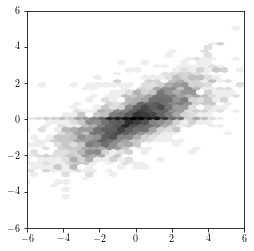

In [124]:
plt.hexbin(ruff['severity_diffs'], ruff['interaction_diffs'], cmap='Greys', bins='log', gridsize=40)
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.gca().set_aspect('equal')

In [ ]:
# 5913
# 8133

In [156]:
df.sort_values('p_values').head(30)

,observed,expected,bias,t_statistics,p_values,labeler_id,measure,race,annotator_race,bias_corrected,bias_abs,annotator_race_name,target_race_name
10641,24.0,36.73,-1.98,-4.91,0.0000,8217,0.66,1.0,0,1.98,1.98,white,black
3504,45.0,32.27,1.69,4.48,0.0001,8217,0.66,0.0,0,-1.69,1.69,white,white
5433,15.0,20.40,-3.52,-5.69,0.0003,941,0.66,1.0,0,3.52,3.52,white,black
3568,8.0,1.17,3.30,5.32,0.0005,8359,0.66,0.0,0,-3.30,3.30,white,white
10666,55.0,46.78,2.12,3.82,0.0006,8261,0.66,1.0,0,-2.12,2.12,white,black
2468,25.0,16.18,1.92,3.94,0.0009,5913,0.66,0.0,0,-1.92,1.92,white,white
9938,40.0,47.00,-1.54,-3.59,0.0012,7276,0.66,1.0,0,1.54,1.54,white,black
1664,20.0,28.23,-1.63,-3.68,0.0016,3994,0.66,0.0,0,1.63,1.63,white,white
4720,36.0,27.73,2.04,3.62,0.0018,11058,0.66,0.0,0,-2.04,2.04,white,white
12708,43.0,51.28,-1.28,-3.43,0.0018,11058,0.66,1.0,0,1.28,1.28,white,black


In [152]:
avg_scores = data.groupby('comment_id')[keys.items].median()

In [157]:
annotator = 7573
df_comment = data[data['labeler_id'] == annotator][['predict_text', 'comment_id', 'target_race_black', 'target_race_white'] + keys.items].reset_index(drop=True)
avg_for_comments = pd.merge(
    left=df_comment,
    right=avg_scores,
    how='left',
    on='comment_id',
    suffixes=('_left', ''))[keys.items]
df_comment[keys.items] = df_comment[keys.items] - avg_for_comments

In [158]:
pd.set_option('display.max_colwidth', None)

In [159]:
df_comment

,predict_text,comment_id,target_race_black,target_race_white,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech
0,Let the DESTRUCTION begin. @swedense You guys are freaking weak for letting That f...ing black monkey out without letting him go to prison for at least 6 years. Keep those black low lifes out our country. All those freaking blacks worthless maggots.,35998,True,False,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0
1,"Wow, Fragile White Redditors out in force tonight.",5735,False,True,1.0,0.0,1.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,This nigga trash throw this man into the compost,44504,True,False,0.5,0.5,0.5,0.0,0.0,-0.5,0.5,0.0,0.0,0.5
3,@Legionary1488 @JomavaesJos now we have a Ebloa case in Texas. If we kill all the niggers we might be safe.,20001,True,False,-1.0,0.0,-2.0,-2.0,-1.0,0.0,0.0,0.0,-1.0,0.0
4,DO YOU SEE HOW QUICK THE PROSECUTED THAT BLACK COP IN MPLS. MN. FOR KILLING THAT WHITE NIGGA??? GUESS BARR HAND A HAND IN THAT TO HUH. THESE NIGGA'S ARE GONNA GET THEIR DAY!!,20006,False,True,0.0,-1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0


In [ ]:
7573

In [142]:
data[data['labeler_id'] == annotator]

,comment_id,labeler_id,raw_text,comment_text,annotator_text,preprocessed_text,predict_text,platform,sentiment,respect,...,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_religion_other_text,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other,annotator_sexuality_other_text
81110,28964,8133,@lashynb13 @Codenamewiz @AllBadArthur The Blac...,@lashynb13 @Codenamewiz @AllBadArthur The Blac...,@lashynb13 @Codenamewiz @AllBadArthur The Blac...,@lashynb13 @codenamewiz @allbadarthur the blac...,@lashynb13 @Codenamewiz @AllBadArthur The Blac...,twitter,3,3,...,False,False,False,False,,False,False,True,False,
114530,30335,8133,Great example of a miserable hoe 🤣 it’s been m...,Great example of a miserable hoe ? it's been m...,Great example of a miserable hoe 🤣 it's been m...,great example of a miserable hoe 🤣 it's been m...,Great example of a miserable hoe 🤣 it's been m...,twitter,4,3,...,False,False,False,False,,False,False,True,False,
203656,49689,8133,Probably a white brit. Those wankers are tryin...,Probably a white brit. Those wankers are tryin...,Probably a white brit. Those wankers are tryin...,probably a white brit. those wankers are tryin...,Probably a white brit. Those wankers are tryin...,youtube,4,3,...,False,False,False,False,,False,False,True,False,
225937,20001,8133,@Legionary1488 @JomavaesJos now we have a Eblo...,@Legionary1488 @JomavaesJos now we have a Eblo...,@Legionary1488 @JomavaesJos now we have a Eblo...,@legionary1488 @jomavaesjos now we have a eblo...,@Legionary1488 @JomavaesJos now we have a Eblo...,reference,4,4,...,False,False,False,False,,False,False,True,False,
237080,20003,8133,#whitepower...I'll hang you nigger,#whitepower...I'll hang you nigger,#whitepower...I'll hang you nigger,#whitepower...i'll hang you nigger,#whitepower...I'll hang you nigger,reference,4,4,...,False,False,False,False,,False,False,True,False,
